<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [1]:
# librerias

import pandas as pd
import numpy as np
import seaborn as sns

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem
import scipy.stats as stats
import pylab as plt

In [2]:
df=pd.read_csv('data/cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
retention_1 = df[["userid", "version", "retention_1"]]
retention_7 = df[["userid", "version", "retention_7"]]

retention_1.head()

,userid,version,retention_1
0,116,gate_30,False
1,337,gate_30,True
2,377,gate_40,True
3,483,gate_40,False
4,488,gate_40,True


# testeo para retention_1

In [4]:
pd.crosstab(df.version, df.retention_1)


retention_1,False,True
version,,
gate_30,24666,20034
gate_40,25370,20119


In [6]:
tasas_conversion=retention_1.groupby('version')['retention_1']

std=lambda x: np.std(x, ddof=0)             # std poblacional
error_std=lambda x: stats.sem(x, ddof=0)    # error estandard (std/sqrt(n))

tasas_conversion=tasas_conversion.agg([np.mean, std, error_std])

tasas_conversion.columns=['conv_rate', 'std', 'error_std']

tasas_conversion.style.format('{:.3f}')

,conv_rate,std,error_std
version,,,
gate_30,0.448,0.497,0.002
gate_40,0.442,0.497,0.002


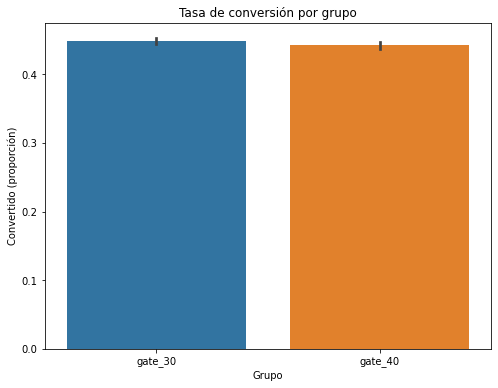

In [7]:
plt.figure(figsize=(8,6))

sns.barplot(x=retention_1['version'], 
            y=retention_1['retention_1'], 
            ci=95 # intervalo de confianza (con el error estandard)
           )

#plt.ylim(0, 0.17)
plt.title('Tasa de conversión por grupo')
plt.xlabel('Grupo')
plt.ylabel('Convertido (proporción)');

In [8]:
control_res=retention_1[retention_1.version=='gate_30']['retention_1']
tratamiento_res=retention_1[retention_1.version=='gate_40']['retention_1']
n_con=control_res.count()   # cuenta de elementos por grupo, ie, conversiones
n_trat=tratamiento_res.count()

conversiones=[control_res.sum(), tratamiento_res.sum()]  # conversiones por grupo

observaciones=[n_con, n_trat] # cuenta N de cada grupo

z_score, p_value = proportions_ztest(conversiones, nobs=observaciones)

z_score, p_value


(1.7840862247974725, 0.07440965529691913)

In [9]:
(gate_30_a, gate_40_a), (gate_30_b, gate_40_b) = proportion_confint(conversiones, 
                                                                           nobs=observaciones,
                                                                           alpha=0.05)

# se definen las dos tuplas de salida del confint

print('Gate 30', [gate_30_a, gate_30_b])
print('Gate 40', [gate_40_a, gate_40_b])

Gate 30 [0.44357771693415227, 0.4527981219920222]
Gate 40 [0.4377186834721228, 0.44684681587936875]


# testeo para retention_7



In [10]:
control_7=retention_7[retention_7.version=='gate_30']

tratamiento_7=retention_7[retention_7.version=='gate_40']
tasas_conversion_7=retention_7.groupby('version')['retention_7']

std=lambda x: np.std(x, ddof=0)             # std poblacional
error_std=lambda x: stats.sem(x, ddof=0)    # error estandard (std/sqrt(n))

tasas_conversion_7=tasas_conversion_7.agg([np.mean, std, error_std])

tasas_conversion_7.columns=['conv_rate', 'std', 'error_std']

tasas_conversion_7.style.format('{:.3f}')

,conv_rate,std,error_std
version,,,
gate_30,0.190,0.392,0.002
gate_40,0.182,0.386,0.002


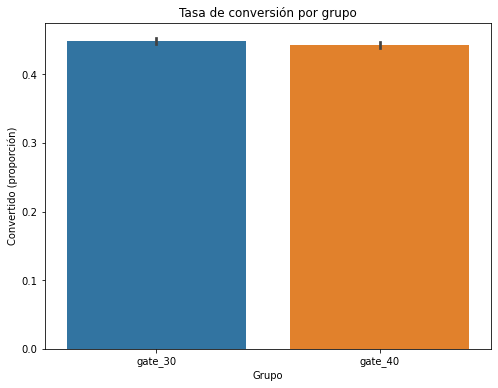

In [11]:
plt.figure(figsize=(8,6))

sns.barplot(x=retention_1['version'], 
            y=retention_1['retention_1'], 
            ci=95 # intervalo de confianza (con el error estandard)
           )

#plt.ylim(0, 0.17)
plt.title('Tasa de conversión por grupo')
plt.xlabel('Grupo')
plt.ylabel('Convertido (proporción)');

In [12]:
control_res=retention_7[retention_7.version=='gate_30']['retention_7']
tratamiento_res=retention_7[retention_7.version=='gate_40']['retention_7']
n_con=control_res.count()   # cuenta de elementos por grupo, ie, conversiones
n_trat=tratamiento_res.count()

conversiones=[control_res.sum(), tratamiento_res.sum()]  # conversiones por grupo

observaciones=[n_con, n_trat] # cuenta N de cada grupo

z_score, p_value = proportions_ztest(conversiones, nobs=observaciones)

z_score, p_value

(3.164358912748191, 0.001554249975614329)

Con los Pvalue obtenidos en las conversiones a 1 días y 7 días, la diferencia de las conversiones
a 1 días no es significativa, sin embargo, a los 7 días sí podemos decir que hay diferencia y las
conversiones son mayores en la puerta 40.